# A step-by-step illustration of the algorithm

This notebook illustrates the calculation of catchmentwide erosion rates with the `riversand` package step by step.<br>
**Make sure to go through `quickstart.ipynb` first!** Then use this notebook for a better understanding of the algorithm or if you want to develop your own customized script for calculating catchmentwide erosion rates.

This script uses the example datasets in the folder `test_data`.

# 1. Input data:
The coloring in this image represents a (hypothetical) distribution of quartz-bearing (blue) and quartz-free (red) lithologies. The shapefile has 8 polygons (red outlines); we will be using the polygon in the western part of the map (yellow outline).  
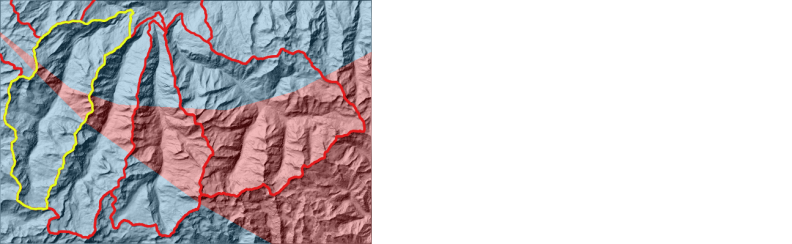

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import riversand
from riversand.params import units

### Raster data
All geospatial data must be projected in an **equal-area projection**; UTM projection is recommended, but other projections are generally accepted. Geographic coordinate reference systems without a projection (e.g., WGS 84) are not permitted.

In [2]:
rv = riversand.Riversand("test_data")

# raster data
rv.add_raster('dem_utm_35m.tif', dtype='elevation')         # projection : UTM zone 32N
#rv.add_raster('dem_LV95.tif', dtype='elevation')            # projection : CH1903+ / LV95
#rv.add_raster('dem_WGS.tif', dtype='elevation')             # geographic coordinate system WGS84, not projected
rv.add_raster('toposhielding_35m.tif', dtype='shielding')   # UTM zone 32N
rv.add_raster('quartz_35m.tif', dtype='quartz')             # UTM zone 32N

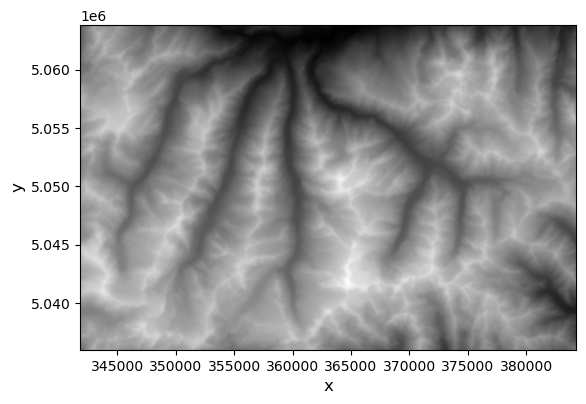

In [3]:
riversand.plot_raster(rv,
                      dtype='elevation', # plot the shielding raster
                      fname='show')      # display; other options are 'jpg' or 'png'

### Sample data
See `quickstart.ipynb` for more information and for importing data from a spreadsheet.

In [4]:
# sample data
rv.add_samples({'N':2.0e4, 'delN': 6.0e2, 'nuclide': 'Be-10'})
rv.add_samples({'N':1.2e5, 'delN': 3.6e3, 'nuclide': 'Al-26'}, add=True)
rv.add_samples({'N':2.0e4, 'delN': 3.0e3, 'nuclide': 'Be-10'}, add=True)
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


### Catchment polygons
The catchment shapefile must have the same projection as the raster data (in this example UTM zone 32N).

The function `.process_multi_catchment()` uses catchment and sample names to match catchment and sample data. Here, we are going to select a catchment manually without worrying about catchment or sample names.

In [5]:
# catchment polygons
rv.add_catchments('test_multi_catchment.shp')        # UTM zone 32N
#rv.add_catchments('test_multi_catchment_LV95.shp')   # projection : CH1903+ / LV95
#rv.add_catchments('test_multi_catchment_WGS.shp')    # geographic coordinate system WGS84, not projected
rv.set_cid('name')
rv.catchments.get_names()

['DB02', 'DB03', 'DB04', 'DB05', 'DB12', 'DB12', 'DB17', 'DB19']

In [6]:
rv.get_valid_catchments() # all samples are named 'Test', therefore no matches are found

[]

### Validation
`rv.validate()` validates that all geospatial data have the same projection and resolution and that there are no invalid entries in the sample data. If the dataset is validated, `rv.crs` and `rv.epsg` return the coordinate reference system and epsg code of the datasets. **Always validate the dataset before proceeding with the next processing steps.**

In [7]:
# all samples are named 'Test', there are no matches with the shapefile polygons
rv.validate()


Raster data valid
Sample data valid
Catchment data valid

Valid catchments / samples:
   No matches found


In [8]:
# show the coordinate reference system of the dataset (nothing is shown here if the validation failed)
rv.crs

<Derived Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 2. Catchment processing:
This section illustrates the calculations that are performed by the functions `.process_single_catchment()` and `.process_multi_catchment()` (see `quickstart.ipynb`). There is no need to understand the following steps in detail; the main goal here is to get a better understanding of the algorithm of erosion rate calculation with the `riversand` package.

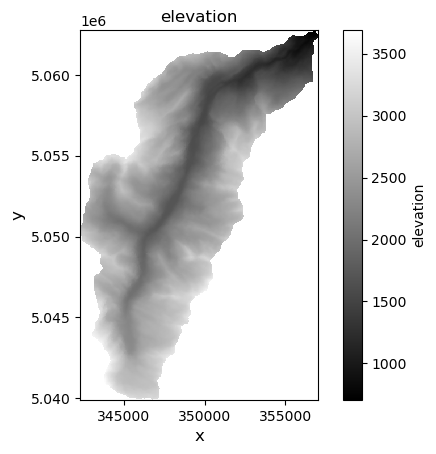

In [9]:
# clip the desired catchment, which happens to be the number n=5 (trial and error...)
clips = rv.clip_all_rasters(n=5)
riversand.plot_clipped_raster(clips,
                              dtype='elevation', # plot the clipped shielding raster
                              fname='show')      # display; other options are 'jpg' or 'png'

In [10]:
# remove the quartz-free areas
clips = riversand.eliminate_quartzfree(clips)

Removed 8.4 % of the catchment as quartz-free


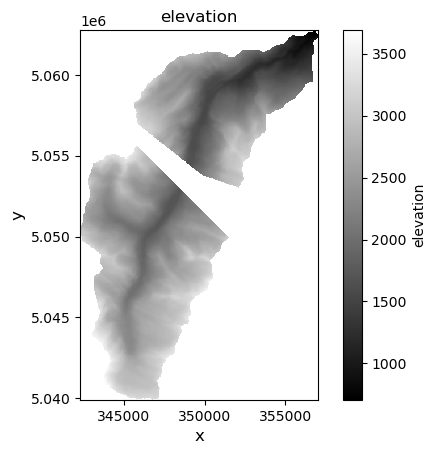

In [11]:
# the quartz-free parts of the catchment are now removed
riversand.plot_clipped_raster(clips,
                              dtype='elevation',
                              fname='show')

The following calculations depend on parameters such as the scaling method or method for shielding correction. To avoid mixing up parameters we first **define the parameters** and use these definitions in the following function calls.

In [12]:
# define parameters for the calculation
bins = 100              # bin size in meters
scaling = 'LSDn'        # 'St', 'Lm' or 'LSDn'
shielding = 'topo'      # 'topo', 'sample' or numeric
unit = 'cm/kyr'         # for plotting only; no effect on calculations

In [13]:
# compute elevation statistics
topostats, summary = riversand.get_topostats(clips, bins=bins, centroid='from_clipped')
topostats.head()

,bin,elevation,shielding,area,lat,long,wt
0,700.0,749.315002,0.943678,0.245000,45.607522,7.054166,0.001690
1,800.0,859.946350,0.942219,0.388325,45.607522,7.054166,0.002678
2,900.0,947.437195,0.942153,0.711725,45.607522,7.054166,0.004909
3,1000.0,1052.943848,0.932430,0.632100,45.607522,7.054166,0.004360
4,1100.0,1154.039551,0.926303,1.084125,45.607522,7.054166,0.007478


The variable `summary` has some statistics of the clipped catchment incl. the 35, 50 and 65 percentile elevations and the centroid latitude and longitude (projected coordinates). These are used to estimate minimum and maximum erosion rates for an optimized determination of the catchmentwide erosion rate. 

In [14]:
summary

{'elevLo': 2274.0,
 'elev50': 2484.0,
 'elevHi': 2688.0,
 'lat': 45.60752151115545,
 'long': 7.054166221307744,
 'areakm2': 144.98119999999997,
 'shielding': 0.9313201,
 'quartz': 0.9161506,
 'epsg': 32632}

## First sample: Be-10

In [15]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [16]:
# select a row from the sample data
i = 0 # first row 
sample_data = rv.samples.iloc[i] 

The sample and nuclide data from the variable `sample_data` and topographic parameters from the variable `summary` are used to estimate a probable range of erosion rates based on the catchment hypsometry:

- The function `.get_textline()` generates input for the online erosion rate calculator<br>
(see http://stoneage.hzdr.de/docs/documentation.html#input_format).

- The function `.get_E()` sends the textline to the server and obtains erosion rates for all implemented scaling methods.

- The function `.guess_erates()` generates suitable erosion rate estiamtes for polynomial fitting.


In [17]:
# minimum estimate from elevation = summary['elevLo']:
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
textline

'Test 45.60752 7.05417 2274.000 std 0.0 2.65 0.93132 0.00000 2010 ; Test Be-10 quartz 20000 600 07KNSTD ;'

In [18]:
# obtain erosion rates from server:
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
E_Lo

{'St': 0.07440000000000001,
 'Lm': 0.07636603773584906,
 'LSDn': 0.08048301886792453}

In [19]:
# maximum estimate from elevation = summary['elevHi']:
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
E_Hi

{'St': 0.09655094339622641,
 'Lm': 0.09950566037735849,
 'LSDn': 0.10743773584905661}

In [20]:
# generate suitable initial erosion rates (scaling specific):
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr
erates

array([0.08048302, 0.08526971, 0.09034108, 0.09571408, 0.10140663,
       0.10743774])

In [21]:
# perform the polynomial fitting:
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )

**Results of the polynomial fitting:**

In [22]:
E, delE # erosion rate and uncertainty in cm/yr

(0.09429829891460603, (0.0028034648519748573, 0.0029718884159832953))

In [23]:
NofE # nuclide concentrations for the inital erosion rates determined by the online calculator

E_cmyr
0.08048    23340.664525
0.08527    22064.910471
0.09034    20856.595018
0.09571    19711.411886
0.10140    18623.447796
0.10740    17593.048650
Name: LSDn, dtype: float64

In [24]:
err # error message

[]

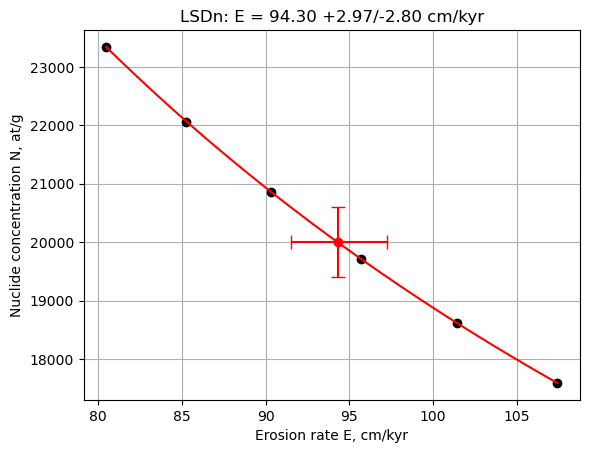

In [25]:
# plot the results
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

- The black points are the erosion rates `erates` sent to the server and the corresponding predicted nuclide concentrations `NofE`.
- The red curve is the polynomial fit to `NofE`
- The red point and vertical error bar are the nuclide concentration of the sample `sample_data['N']` and uncertainty `sample_data['delN']`
- The horizontal error bar is the uncertainty on the erosion rate `delE` resulting from the analytical uncertainty `delN`; it depends on the shape of the function $N(E)$ and is therefore asymmetric. Use the upper value (`delE[1]`) for a more conservative estimate of the analytical uncertainty in `E`.

In [26]:
# print the result E, delE[1] in a pretty format
u = units[unit]
print("{} : {:.1f} +/-{:.1f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Be-10 : 94.3 +/-3.0 cm/kyr (LSDn)


## Second sample: Al-26

In [27]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [28]:
# select a row from the sample data
i = 1 # second row 
sample_data = rv.samples.iloc[i]

In [29]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

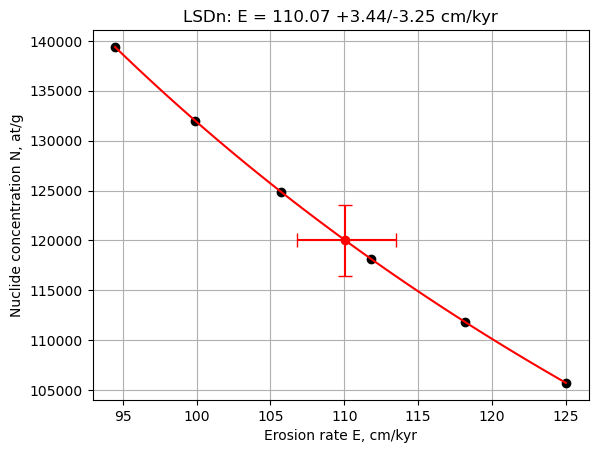

In [30]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [31]:
print("{} : {:.1f} +/-{:.1f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Al-26 : 110.1 +/-3.4 cm/kyr (LSDn)


## Third sample: Be-10 with a 5 times higher uncertainty than first sample

In [32]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [33]:
# select a row from the sample data
i = 2 # third row 
sample_data = rv.samples.iloc[i]

In [34]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

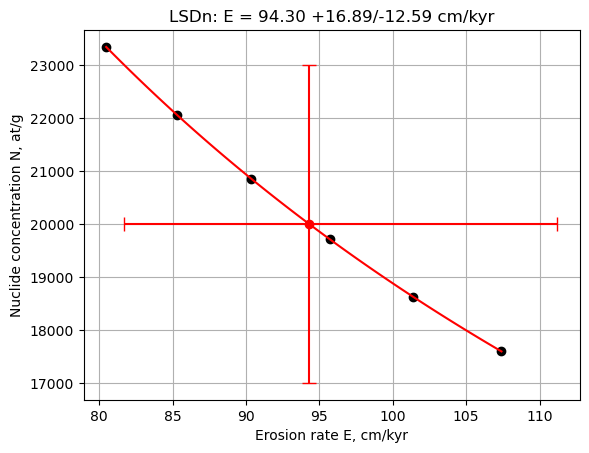

In [35]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [36]:
print("{} : {:.1f} +/-{:.1f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Be-10 : 94.3 +/-16.9 cm/kyr (LSDn)


# 3. Plotting functions

### `riversand.plot_raster(rv)`

Generates a plot of the raster(s) uploaded to the variable `rv`. It has two optional arguments:

- `dtype` is the type of raster to be plotted, i.e. `'elevation'`, `'shielding'` or `'quartz'` (default: `'elevation'`)<br>
- `fname` may have one of the following values (default: `'show'`):
    - `'show'`: show the plot inline
    - `'jpg'` or `'png'`: save the plot under an auto-generated name
    - `'my_custom_name.jpg`: save the plot under a custom name
    
Auto-generated file names are `_Elevation.jpg`, `_Shielding.png` etc.

In [37]:
riversand.plot_raster(rv, dtype='shielding', fname='custom_name')

### `riversand.plot_clipped_raster(clips)`

Generates a plot of the clipped catchments (`clips`). It has three optional arguments:

- `dtype` is the type of raster to be plotted, i.e. `'elevation'`, `'shielding'` or `'quartz'` (default: `'elevation'`)<br>
- `c_name` is a catchment name used as prefix for the auto-generated name
- `fname` may have one of the following values (default: `'jpg'`):
    - `'show'`: show the plot inline
    - `'jpg'` or `'png'`: save the plot under an auto-generated name
    - `'my_custom_name.jpg`: save the plot under a custom name

 
Auto-generated file names are `elevation.jpg`, `shielding.png` etc.,<br>
or `Ph-1_elevation.jpg` etc. if the catchment name is specified (`c_name='Ph-1'`).

In [38]:
riversand.plot_clipped_raster(clips, c_name='Ph-1', dtype='shielding')

### `riversand.plot_polyfit(E, delE, NofE, sample_data)`

Plots the results of `E, delE, NofE, err = riversand.poly_E_results(sample_data, ...)`. Optional arguments are:

- `unit`: unit of erosion rate used for plotting, e.g. `'mm/yr'` or `'cm/kyr'`; see `riversand.params.units` for valid options
- `fname` may have one of the following values (default: `'jpg'`):
    - `'show'`: show the plot inline
    - `'jpg'` or `'png'`: save the plot under an auto-generated name
    - `'my_custom_name.jpg`: save the plot under a custom name

Auto-generated file names include the sample name and scaling method, e.g. `Test_Lm.jpg` etc.;<br>
a custom sample name can be specified with the parameter `c_name`.

In [39]:
riversand.plot_polyfit(E, delE, NofE, sample_data, fname='jpg')

In [40]:
riversand.plot_polyfit(E, delE, NofE, sample_data, fname='jpg', c_name='Ph-1')

# Finally:
### Some comments on the choice of initial erosion rates:
The functions `.process_single_catchment()`and `.process_multi_catchment()` optimize the choice of a suitable set of initial erosion rates `erates`. You can customize the initial erosion rates, even though this is generally not necessary or even useful:

In [41]:
sample_data = rv.samples.iloc[0]

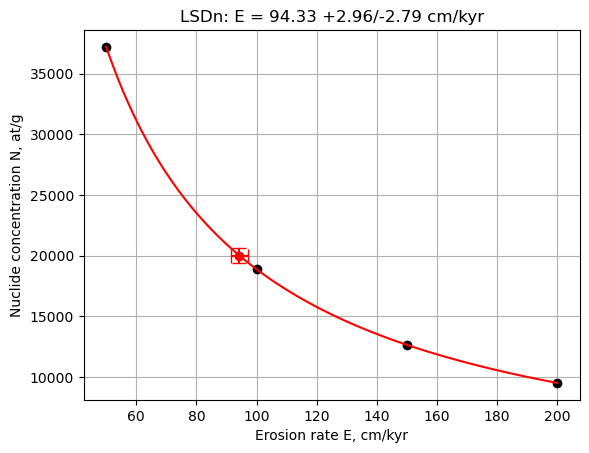

In [42]:
# (1) Custom initial erosion rates:
unit = 'cm/kyr'
erates = [0.05, 0.10, 0.15, 0.20] # cm/yr
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

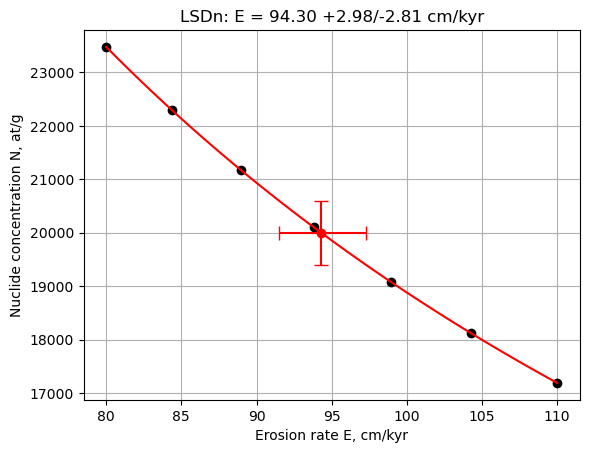

In [43]:
# (2) Using the function .guess_erates() for logarithmically distributed values
erates = riversand.guess_erates(0.08, 0.11, N=7)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

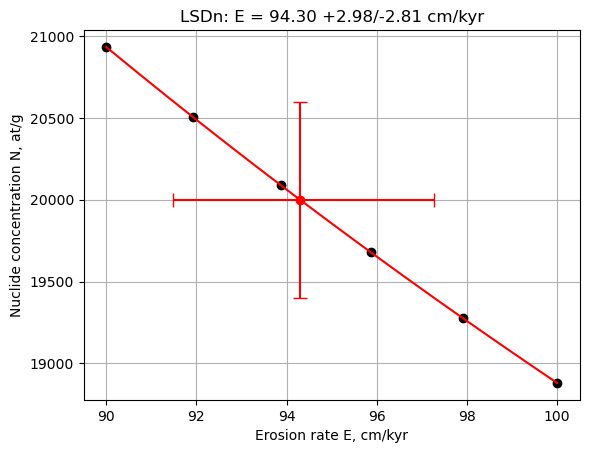

In [44]:
# (3) Using narrower brackets 
erates = riversand.guess_erates(0.09, 0.10, N=6)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [45]:
# (4) Note that you may get error messages for an unsuitable choice of initial erosion rates
erates = riversand.guess_erates(0.08, 0.09, N=6)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
err

['maxE too low']

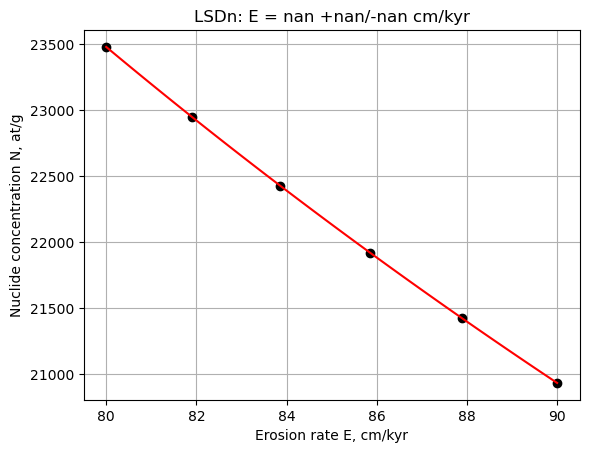

In [46]:
# erosion rate is outside of the range of NofE: nothing much to plot
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

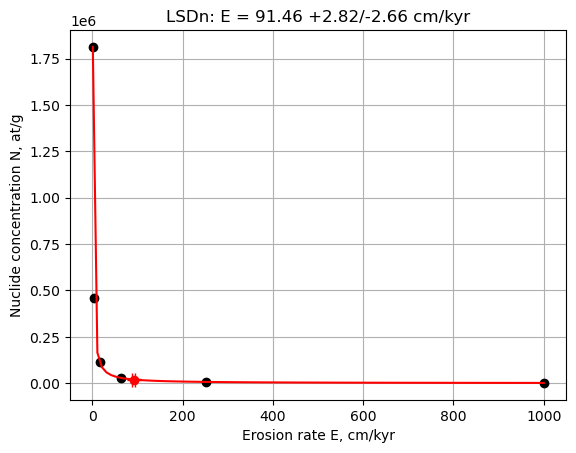

In [47]:
# (5) Unsuitable initial erosion rates may also result in a poor fit of the polynomial function
erates = riversand.guess_erates(0, 1)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

#NRMSE = riversand.get_RMSE(NofE)/sample_data['N']

In [48]:
err

['NRMSE = 3.16e-02 suggests a poor fit of the polynomial']

### Extremely high and very low erosion rates
The algorithm becomes unstable for extremely low and extremely high nuclide concentrations; try the following code with concentrations of **N = 100 atoms/gram** or **N = 5E+7 atoms/gram**. It is, of course, highly questionable that such nuclide concentrations reflect a catchmentwide erosion rate...

In [49]:
#extremely low nuclide concentrations:
sample_data = {'N': 5e7, 'delN': 1e6}

# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

unit = 'mm/kyr'
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

RuntimeError: get_E() : sample appears to be saturated